# **Method**

1. Extract relevant eReefs variables from hydrodynamic and biogeochemical datasets

2. Combine eReefs variables (*current speed* and *chlorophyll concentration*) into a single dataframe

3. Visualize temporal trends between eReefs variables

4. Extract relevant variables from total and resident manta datasets and combine with eReefs dataframe

5. Visualize temporal trends between manta detections and eReefs variables 

6. Perform regression analysis to test correlation between manta and eReefs data

In [1]:
# Load dependencies
from siphon.catalog import TDSCatalog
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from netCDF4 import num2date
import pandas as pd
import os

In [2]:
# Define base directory
base_dir = "CombinedVariables_Outputs"

# Define subfolders
folders = {
    "data": os.path.join(base_dir, "data"),
    "plots": os.path.join(base_dir, "plots"),
    "regression": os.path.join(base_dir, "regression")
}

# Create all folders
for path in folders.values():
    os.makedirs(path, exist_ok=True)

# Step 1 - Extract eReefs Data

## **Load Data From eReefs Models**

### Hydrodynamic Model

In [3]:
# Initialise variables specific to this dataset
hydro_catUrl = "https://thredds.ereefs.aims.gov.au/thredds/catalog/ereefs/gbr4_v4.xml"
datasetName = "Hydrodynamic model - 4km grid (gbr4_v4) - daily"

In [4]:
hydro_catalog = TDSCatalog(hydro_catUrl)

In [5]:
hydro_ds = hydro_catalog.datasets[datasetName]
hydro_ds.name

'Hydrodynamic model - 4km grid (gbr4_v4) - daily'

In [6]:
list(hydro_ds.access_urls)

['OPeNDAP', 'WCS', 'WMS', 'NetcdfSubset', 'CdmRemote']

In [7]:
hydro_dataset = hydro_ds.remote_access()

### Biogeochemical Model

In [8]:
# Initialise variables specific to this dataset
bio_catUrl = "https://thredds.ereefs.aims.gov.au/thredds/catalog/ereefs/GBR4_H2p0_B3p1_Cq3b_Dhnd.xml"
datasetName = "BioGeoChemical model - Baseline scenario (GBR4_H2p0_B3p1_Cq3b_Dhnd) - daily"

In [9]:
bio_catalog = TDSCatalog(bio_catUrl)

In [10]:
bio_ds = bio_catalog.datasets[datasetName]
bio_ds.name

'BioGeoChemical model - Baseline scenario (GBR4_H2p0_B3p1_Cq3b_Dhnd) - daily'

In [11]:
list(bio_ds.access_urls)

['OPeNDAP', 'WCS', 'WMS', 'NetcdfSubset', 'CdmRemote']

In [12]:
bio_dataset = bio_ds.remote_access()

## **Select Variables**

### Variables of Interest

*Current Speed*

In [13]:
# === Select current variable ===
cur_var = hydro_dataset.variables['mean_cur']

*Chlorophyll*

In [14]:
# === Select chlorophyll variable ===
chl_var = bio_dataset.variables['Chl_a_sum']

### Dimension Variables

Identify and convert time variable

In [15]:
# Loop through dimension variables in each dataset to get "time" variable
for dim_var in hydro_dataset.variables.values():
    for dim_var in bio_dataset.variables.values():
        if 'coordinate_type' in dim_var.ncattrs():
            if dim_var.coordinate_type == 'time':
                time_var = dim_var

# Fetch time variable for each dataset and store NetCDF time array as "time_dim"
time_dim = hydro_dataset.variables[cur_var.dimensions[0]]
time_dim = bio_dataset.variables[chl_var.dimensions[0]]

# Convert NetCDF time to datetime (to index datetime in future dataframes)
time = num2date(time_dim[:], time_dim.units)
time_py = pd.to_datetime([t.strftime('%Y-%m-%d') for t in time])
print("Number of time steps:", len(time_py))

Number of time steps: 3073


Define and inspect latitude and longitude variables 

In [16]:
# Hydrodynamic dataset
lat = hydro_dataset.variables['latitude'][:]
lon = hydro_dataset.variables['longitude'][:]

# Biogeochemical dataset
lat = bio_dataset.variables['latitude'][:]
lon = bio_dataset.variables['longitude'][:]

# Inspect coordinate range for datasets
print("Latitude range:", lat.min(), "to", lat.max())
print("Longitude range:", lon.min(), "to", lon.max())

Latitude range: -28.696022 to -7.036022
Longitude range: 142.168788 to 156.868788


Define bounding box around Lady Elliot Island

In [17]:
# Set range of coordinates around LEI
lat_min, lat_max = -24.14, -24.09
lon_min, lon_max = 152.70, 152.73

# Produce indices of latitudes and longitudes within the defined LEI range 
lat_idx = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lon_idx = np.where((lon >= lon_min) & (lon <= lon_max))[0]

# Inspect indices to ensure they contain values 
if len(lat_idx) == 0 or len(lon_idx) == 0:
    raise ValueError("⚠️ Bounding box did not capture any grid cells. Try expanding slightly.")

# Inspect subset values to ensure they fall within range
print(f"Selected lat indices: {lat_idx[0]}–{lat_idx[-1]}")
print(f"Selected lon indices: {lon_idx[0]}–{lon_idx[-1]}")
print(f"Latitude range subset: {lat[lat_idx[0]]:.3f}–{lat[lat_idx[-1]]:.3f}")
print(f"Longitude range subset: {lon[lon_idx[0]]:.3f}–{lon[lon_idx[-1]]:.3f}")

Selected lat indices: 152–153
Selected lon indices: 352–352
Latitude range subset: -24.136–-24.106
Longitude range subset: 152.729–152.729


Inspect and select 'zc' variable (depth)

In [18]:
# Define zc variable
zc = hydro_dataset.variables['zc'][:]   
zc = bio_dataset.variables['zc'][:]  

# Inspect data to determine which zc value represents a depth of 0.5 meters
target_depth = 0.5
depth_idx = np.abs(zc - target_depth).argmin()
print(f"Using zc index {depth_idx} at depth {zc[depth_idx]:.2f} m (surface layer)")

Using zc index 16 at depth -0.50 m (surface layer)


## **Extract eReefs Datasets**

Extract values within coordinate range (Lady Elliot Bounding Box) and compute average

In [20]:
# ***
# NOTE: running this cell will take a longtime, give it time to finish executing
# ***

# Create lists to store annual time series data
cur_list = []
chl_list = []

# Loop through years of interest
for yr in [2011, 2012, 2013]:
    print(f"Loading year {yr}...")
    start = pd.Timestamp(f"{yr}-01-01")
    end = pd.Timestamp(f"{yr}-12-31")

    # Find time indices for each year 
    time_idx = np.where((time_py >= start) & (time_py <= end))[0]
    if len(time_idx) == 0:
        continue

    # Slice time index to extract every timestep per year (+1 ensures the last index is included)
    time_slice = slice(time_idx[0], time_idx[-1] + 1)
    
    # Extract subset of values within the defined spatial range (depth, lat, lon)
    cur_year = cur_var[time_slice, depth_idx, lat_idx[0]:lat_idx[-1]+1, lon_idx[0]:lon_idx[-1]+1].data
    chl_year = chl_var[time_slice, depth_idx, lat_idx[0]:lat_idx[-1]+1, lon_idx[0]:lon_idx[-1]+1].data
    
    # Calculate average across spatial range (mean within LEI bounding box) for each timestep
    cur_list.append(np.nanmean(cur_year, axis=(1, 2)))
    chl_list.append(np.nanmean(chl_year, axis=(1, 2)))

Loading year 2011...


HTTPError: Error accessing https://thredds.ereefs.aims.gov.au/thredds/cdmremote/GBR4_H2p0_B3p1_Cq3b_Dhnd/daily.nc?req=data&var=%2FChl_a_sum%2831%3A395%2C16%2C152%3A153%2C352%3A352%29
Server Error ( 504: Gateway Time-out)

Combine lists to form a continuous daily time series for each variable

In [20]:
# Combine all yearly arrays (2011 - 2013) to produce a continuous timeseries
cur_mean_daily = np.concatenate(cur_list)
chl_mean_daily = np.concatenate(chl_list)

ValueError: need at least one array to concatenate

# Step 2 - Combine eReefs Variable Dataframes

## **Create Dataframe**

Convert Arrays to Dataframes

In [76]:
# Current Speed
cur_df = pd.DataFrame({
    'time': time_py[(time_py >= '2011-01-01') & (time_py <= '2013-12-31')],
    'current_speed': cur_mean_daily
}).set_index('time')

In [81]:
# Chlorophyll
chl_df = pd.DataFrame({
    'time': time_py[(time_py >= '2011-01-01') & (time_py <= '2013-12-31')],
    'chlorophyll': chl_mean_daily
}).set_index('time')

Inspect Dataframes

In [82]:
cur_df.head()

,current_speed
time,
2011-01-01,0.283757
2011-01-02,0.316850
2011-01-03,0.351606
2011-01-04,0.380222
2011-01-05,0.406237


In [83]:
chl_df.head()

,chlorophyll
time,
2011-01-01,0.826464
2011-01-02,0.749699
2011-01-03,0.735544
2011-01-04,0.632903
2011-01-05,0.703904


Call csv file into Jupyter environment and parse 'time' column as dates

In [19]:
csv_path = os.path.join("CombinedVariables_Outputs", "data", "mean_daily_current_speed.csv")
cur_df = pd.read_csv(csv_path, parse_dates=['time'], index_col='time')

csv_path = os.path.join("CombinedVariables_Outputs", "data", "mean_daily_chlorophyll.csv")
chl_df = pd.read_csv(csv_path, parse_dates=['time'], index_col='time')

## **Combine Dataframes**

Concate chlorophyll and current speed dataframes

In [20]:
combined_df = pd.concat([chl_df, cur_df], axis=1)

combined_df.head

<bound method NDFrame.head of             chlorophyll  current_speed
time                                  
2011-01-01     0.826464       0.283757
2011-01-02     0.749699       0.316850
2011-01-03     0.735544       0.351606
2011-01-04     0.632903       0.380222
2011-01-05     0.703904       0.406237
...                 ...            ...
2013-12-27     0.533179       0.274444
2013-12-28     0.516986       0.235093
2013-12-29     0.529939       0.241881
2013-12-30     0.656273       0.278987
2013-12-31     0.609870       0.298490

[1096 rows x 2 columns]>

Save combined dataframe as csv file

In [29]:
csv_path = os.path.join("CombinedVariables_Outputs", "data", "combined_current_chlorophyll.csv")
combined_df = pd.read_csv(csv_path)

Ensure combined dataframe has a datetime index

In [31]:
# --- Ensure 'time' is datetime ---
combined_df['time'] = pd.to_datetime(combined_df['time'], errors='coerce')

# --- Set as index ---
combined_df.set_index('time', inplace=True)

In [32]:
print(combined_df.index.dtype)

datetime64[ns]


# Step 3 - Visualize eReefs Data

## **Visualize Data**

### Daily Average and Monthly Mean

*Current Speed*

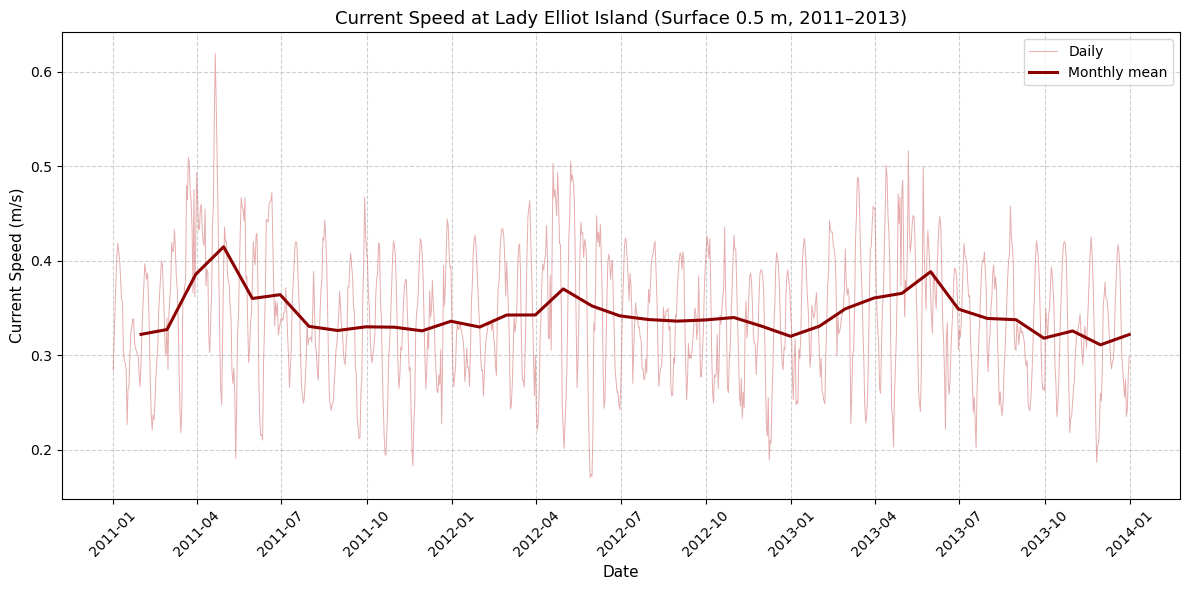

In [33]:
# === Plot: Daily and Monthly Mean Current Speed (2011–2013) ===
import matplotlib.dates as mdates

# Compute monthly mean for smoother trendline
cur_monthly = cur_df['current_speed'].resample('ME').mean()

plt.figure(figsize=(12, 6))

# Plot daily mean (fine detail)
plt.plot(cur_df.index, cur_df['current_speed'],
         color='indianred', lw=0.7, alpha=0.5, label='Daily')

# Overlay monthly mean (smoothed seasonal pattern)
plt.plot(cur_monthly.index, cur_monthly,
         color='darkred', lw=2.2, label='Monthly mean')

# Labels & titles
plt.xlabel('Date', fontsize=11)
plt.ylabel('Current Speed (m/s)', fontsize=11)
plt.title('Current Speed at Lady Elliot Island (Surface 0.5 m, 2011–2013)', fontsize=13)

# Formatting
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plot_path = os.path.join(folders["plots"], "current_speed_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

*Chlorophyll*

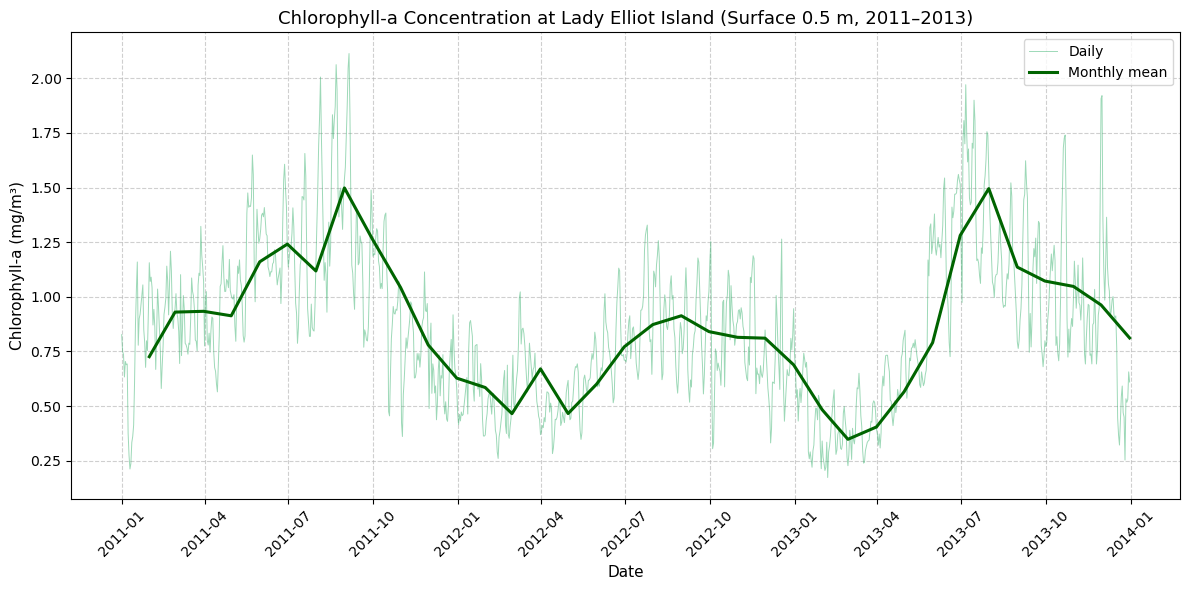

In [34]:
# === Plot: Daily and Monthly Mean Chlorophyll-a (2011–2013) ===

# Compute monthly mean for smoother trendline
chl_monthly = chl_df['chlorophyll'].resample('ME').mean()

plt.figure(figsize=(12, 6))

# Plot daily mean (fine detail)
plt.plot(chl_df.index, chl_df['chlorophyll'],
         color='mediumseagreen', lw=0.7, alpha=0.5, label='Daily')

# Overlay monthly mean (smoothed seasonal pattern)
plt.plot(chl_monthly.index, chl_monthly,
         color='darkgreen', lw=2.2, label='Monthly mean')

# Labels & titles
plt.xlabel('Date', fontsize=11)
plt.ylabel('Chlorophyll-a (mg/m³)', fontsize=11)
plt.title('Chlorophyll-a Concentration at Lady Elliot Island (Surface 0.5 m, 2011–2013)', fontsize=13)

# Formatting
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)
plt.tight_layout()
plot_path = os.path.join(folders["plots"], "chlorophyll_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

## **Visualize Combined Data**

### Average Daily Chlorophyll and Current Speed

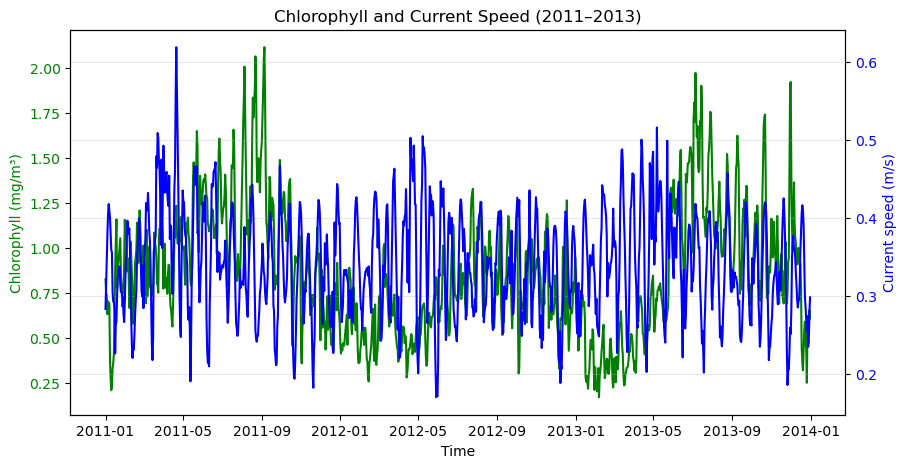

In [35]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot chlorophyll on left axis
ax1.plot(combined_df.index, combined_df['chlorophyll'], color='green', label='Chlorophyll (mg/m³)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Chlorophyll (mg/m³)', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create second axis for current speed
ax2 = ax1.twinx()
ax2.plot(combined_df.index, combined_df['current_speed'], color='blue', label='Current speed (m/s)')
ax2.set_ylabel('Current speed (m/s)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and grid
plt.title('Chlorophyll and Current Speed (2011–2013)')
plt.grid(alpha=0.3)
plt.show()

### Average Monthly Chlorophyll and Current Speed

Compute monthly averages

In [36]:
monthly_df = combined_df.resample('ME').mean()

print(monthly_df.head)

<bound method NDFrame.head of             chlorophyll  current_speed
time                                  
2011-01-31     0.725755       0.322063
2011-02-28     0.929797       0.327145
2011-03-31     0.933406       0.385681
2011-04-30     0.912898       0.414752
2011-05-31     1.160089       0.360026
2011-06-30     1.241044       0.364058
2011-07-31     1.118115       0.330495
2011-08-31     1.498147       0.326121
2011-09-30     1.266815       0.330018
2011-10-31     1.042365       0.329628
2011-11-30     0.779597       0.325774
2011-12-31     0.627628       0.335922
2012-01-31     0.584580       0.329795
2012-02-29     0.465044       0.342484
2012-03-31     0.670066       0.342599
2012-04-30     0.465453       0.370143
2012-05-31     0.600371       0.352147
2012-06-30     0.770865       0.341602
2012-07-31     0.872684       0.337730
2012-08-31     0.913031       0.336055
2012-09-30     0.840526       0.337290
2012-10-31     0.814385       0.339867
2012-11-30     0.810517       0.33

Create monthly average plot

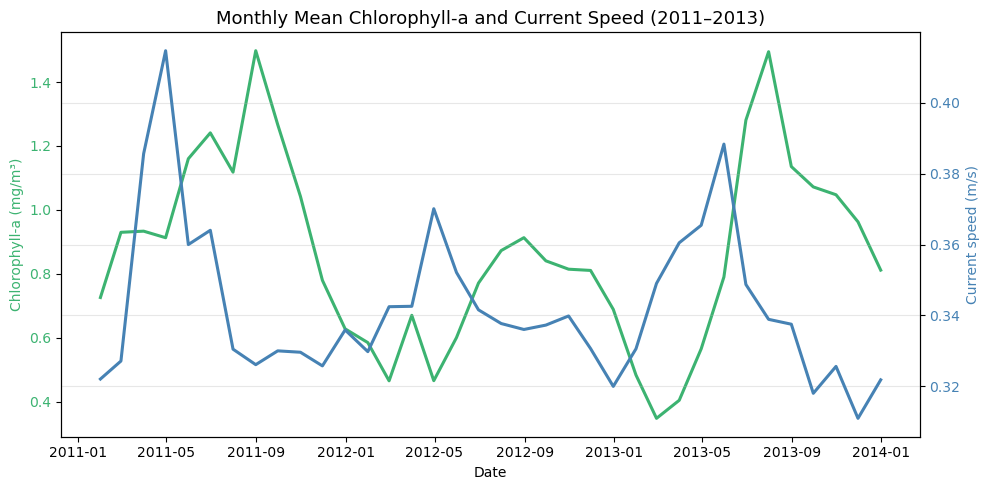

In [38]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

# Chlorophyll (left axis)
ax1.plot(monthly_df.index, monthly_df['chlorophyll'],
         color='mediumseagreen', lw=2.2, label='Chlorophyll-a (mg/m³)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Chlorophyll-a (mg/m³)', color='mediumseagreen')
ax1.tick_params(axis='y', labelcolor='mediumseagreen')

# Current speed (right axis)
ax2 = ax1.twinx()
ax2.plot(monthly_df.index, monthly_df['current_speed'],
         color='steelblue', lw=2.2, label='Current speed (m/s)')
ax2.set_ylabel('Current speed (m/s)', color='steelblue')
ax2.tick_params(axis='y', labelcolor='steelblue')

# Title, grid, and layout
plt.title('Monthly Mean Chlorophyll-a and Current Speed (2011–2013)', fontsize=13)
plt.grid(alpha=0.3)
plt.tight_layout()
plot_path = os.path.join(folders["plots"], "combined_current_chlorophyll_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

# Step 4 - Extract Manta Data and Combine with eReefs Data

## **Extract Resident Manta Data**

Import manta file

In [54]:
excel_path = os.path.join("CombinedVariables_Inputs", "manta_daily_summary.xlsx")

Create and inspect manta dataframe

In [55]:
manta_df = pd.read_excel(excel_path)

In [56]:
manta_df.head()

,transmitter_id,date,total_detections,valid_hours,avg_detections_per_hour,date_dt
0,A69-1601-32687,2011-06-20,55,5,11.000000,2011-06-20
1,A69-1601-32687,2011-06-28,22,2,11.000000,2011-06-28
2,A69-1601-32687,2011-06-29,139,12,11.583333,2011-06-29
3,A69-1601-32687,2011-06-30,42,7,6.000000,2011-06-30
4,A69-1601-32687,2011-07-05,95,9,10.555556,2011-07-05


Convert dataframe to csv file

In [57]:
csv_path = os.path.join(folders["data"], "daily_manta_data.csv")

manta_df.to_csv(csv_path, index=False)

Extract and process variables of interest

In [58]:
# Extract variable of interest
daily_detections_df = manta_df[['date', 'total_detections']]

# Rename 'time' column 'date' for clarity
daily_detections_df.rename(columns={'date': 'time'}, inplace=True)
daily_detections_df.rename(columns={'total_detections': 'resident_detections'}, inplace=True)

daily_detections_df.head()

/tmp/ipykernel_53/404061313.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_detections_df.rename(columns={'date': 'time'}, inplace=True)
/tmp/ipykernel_53/404061313.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_detections_df.rename(columns={'total_detections': 'resident_detections'}, inplace=True)


,time,resident_detections
0,2011-06-20,55
1,2011-06-28,22
2,2011-06-29,139
3,2011-06-30,42
4,2011-07-05,95


## **Combine Dataframes (Resident Mantas + eReefs Variables)**

Inspect that the datetime columns will align

In [59]:
print(combined_df.index)
print(combined_df.index.dtype)

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2013-12-22', '2013-12-23', '2013-12-24', '2013-12-25',
               '2013-12-26', '2013-12-27', '2013-12-28', '2013-12-29',
               '2013-12-30', '2013-12-31'],
              dtype='datetime64[ns]', name='time', length=1096, freq=None)
datetime64[ns]


In [60]:
print(daily_detections_df['time'].dtype) 

datetime64[ns]


Convert datetime format to align with variable dataframe

In [61]:
# Make sure 'time' is datetime
daily_detections_df['time'] = pd.to_datetime(daily_detections_df['time'], errors='coerce')

# Set 'time' as the index
daily_detections_df.set_index('time', inplace=True)

# Check index
print(daily_detections_df.index)
print(daily_detections_df.index.dtype)  # should now be datetime64[ns]

DatetimeIndex(['2011-06-20', '2011-06-28', '2011-06-29', '2011-06-30',
               '2011-07-05', '2011-07-06', '2011-07-07', '2011-07-08',
               '2011-07-09', '2011-07-11',
               ...
               '2013-03-28', '2013-03-29', '2013-03-30', '2013-03-31',
               '2013-04-01', '2013-04-02', '2013-04-03', '2013-04-04',
               '2013-04-05', '2013-04-06'],
              dtype='datetime64[ns]', name='time', length=979, freq=None)
datetime64[ns]


/tmp/ipykernel_53/3774965135.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_detections_df['time'] = pd.to_datetime(daily_detections_df['time'], errors='coerce')


Merge dataframes and add NaN values to missing dates in manta dataframe

In [62]:
# Merge with combined_df (left join keeps all dates)
merged_df = combined_df.merge(
    daily_detections_df,
    how='left',
    left_index=True,  # combined_df's datetime index
    right_on='time'   # detections datetime column
)

# Set the index back to datetime for resampling
merged_df.set_index('time', inplace=True)

# Check index
print(merged_df.index)
print(merged_df.index.dtype) 

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2013-12-22', '2013-12-23', '2013-12-24', '2013-12-25',
               '2013-12-26', '2013-12-27', '2013-12-28', '2013-12-29',
               '2013-12-30', '2013-12-31'],
              dtype='datetime64[ns]', name='time', length=1387, freq=None)
datetime64[ns]


Inspect merged dataframe

In [63]:
print(merged_df.head())
print(merged_df.index)
print(merged_df.index.dtype)
print(merged_df.columns)

            chlorophyll  current_speed  resident_detections
time                                                       
2011-01-01     0.826464       0.283757                  NaN
2011-01-02     0.749699       0.316850                  NaN
2011-01-03     0.735544       0.351606                  NaN
2011-01-04     0.632903       0.380222                  NaN
2011-01-05     0.703904       0.406237                  NaN
DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2013-12-22', '2013-12-23', '2013-12-24', '2013-12-25',
               '2013-12-26', '2013-12-27', '2013-12-28', '2013-12-29',
               '2013-12-30', '2013-12-31'],
              dtype='datetime64[ns]', name='time', length=1387, freq=None)
datetime64[ns]
Index(['chlorophyll', 'current_speed', 'resident_detections'], dtype='object')


Compute monthly averages for variables and sum for resident manta detections

In [64]:
merged_monthly = merged_df.resample('ME').agg({
    'chlorophyll': 'mean',
    'current_speed': 'mean',
    'resident_detections': 'sum'
})

merged_monthly.head()

,chlorophyll,current_speed,resident_detections
time,,,
2011-01-31,0.725755,0.322063,0.0
2011-02-28,0.929797,0.327145,478.0
2011-03-31,0.933406,0.385681,570.0
2011-04-30,0.912898,0.414752,151.0
2011-05-31,1.160089,0.360026,976.0


## **Extract Total Manta Data**

Import full manta file

In [65]:
import pandas as pd

file_path = os.path.join("CombinedVariables_Inputs", "All_Manta_Data.xlsx")

cols_to_use = ["detection_datetime", "transmitter_id"]
all_detections_df = pd.read_excel(file_path, usecols=cols_to_use)

In [66]:
all_detections_df = all_detections_df.drop(columns=['Unnamed: 0'], errors='ignore')

all_detections_df.head()

,detection_datetime,transmitter_id
0,2011-01-06 02:37:05,A69-1303-14680
1,2011-01-06 05:12:11,A69-1303-14680
2,2011-01-06 07:25:20,A69-1303-14680
3,2011-01-06 08:04:02,A69-1303-14680
4,2011-01-06 08:11:07,A69-1303-14680


In [69]:
csv_path = os.path.join(folders['data'], "all_detections.csv")

all_detections_df.to_csv(csv_path, index=False)

Create and inspect dataframe

In [70]:
print(all_detections_df["detection_datetime"].head())
print(all_detections_df["detection_datetime"].min(), all_detections_df["detection_datetime"].max())

0   2011-01-06 02:37:05
1   2011-01-06 05:12:11
2   2011-01-06 07:25:20
3   2011-01-06 08:04:02
4   2011-01-06 08:11:07
Name: detection_datetime, dtype: datetime64[ns]
2011-01-06 02:37:05 2015-12-22 00:30:17


In [71]:
# Convert to datetime
all_detections_df["detection_datetime"] = pd.to_datetime(
    all_detections_df["detection_datetime"], errors="coerce"
)

# Filter to 2011-01-01 → 2013-12-31
all_detections_df = all_detections_df[
    (all_detections_df["detection_datetime"] >= "2011-01-01") &
    (all_detections_df["detection_datetime"] <= "2013-12-31")
]

# Extract date only (drops time)
all_detections_df["date_only"] = all_detections_df["detection_datetime"].dt.date

# Compute daily total detections (group by date only)
daily_total = all_detections_df.groupby("date_only").size().rename("total_detections")

# Create full daily date range
date_range = pd.date_range(start="2011-01-01", end="2013-12-31", freq="D")

# Reindex to fill missing days with NaN
all_daily_detections = daily_total.reindex(date_range)
all_daily_detections.index.name = "time"
all_daily_detections = all_daily_detections.to_frame()

print(all_daily_detections.head(10))
print(all_daily_detections.tail(10))
print(all_daily_detections.dtypes)


            total_detections
time                        
2011-01-01               NaN
2011-01-02               NaN
2011-01-03               NaN
2011-01-04               NaN
2011-01-05               NaN
2011-01-06              19.0
2011-01-07              27.0
2011-01-08               NaN
2011-01-09               NaN
2011-01-10               NaN
            total_detections
time                        
2013-12-22              38.0
2013-12-23               NaN
2013-12-24               NaN
2013-12-25               NaN
2013-12-26               NaN
2013-12-27               4.0
2013-12-28              24.0
2013-12-29               NaN
2013-12-30               NaN
2013-12-31               NaN
total_detections    float64
dtype: object


/tmp/ipykernel_53/2399672034.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_detections_df["date_only"] = all_detections_df["detection_datetime"].dt.date


Inspect time variable before combining datasets

In [72]:
print(all_daily_detections.index.dtype)  # should be datetime64[ns]
print(all_daily_detections.dtypes)       # check column data types

datetime64[ns]
total_detections    float64
dtype: object


## **Combine Dataframes (All Mantas + eReefs Variables)**

Merge dataframes

In [73]:
# Merge directly using the index
all_merged_df = merged_df.merge(
    all_daily_detections,
    how='left',
    left_index=True,
    right_index=True
)

Inspect the combined dataframe

In [74]:
all_merged_df.head(60)

,chlorophyll,current_speed,resident_detections,total_detections
time,,,,
2011-01-01,0.826464,0.283757,NaN,NaN
2011-01-02,0.749699,0.316850,NaN,NaN
2011-01-03,0.735544,0.351606,NaN,NaN
2011-01-04,0.632903,0.380222,NaN,NaN
2011-01-05,0.703904,0.406237,NaN,NaN
2011-01-06,0.688868,0.418232,NaN,19.0
2011-01-07,0.692456,0.408683,NaN,27.0
2011-01-08,0.375736,0.400414,NaN,NaN
2011-01-09,0.273445,0.380125,NaN,NaN


In [117]:
all_merged_df.dtypes

chlorophyll            float64
current_speed          float64
resident_detections    float64
total_detections       float64
dtype: object

Convert dataframe to csv file

In [11]:
csv_path = os.path.join(folders["data"], "all_merged_data.csv")
all_merged_df.to_csv(csv_path, index=False)

NameError: name 'all_merged_df' is not defined

Call csv file back into notebook (if re-runing code and not wanting to reload dataframe)

In [19]:
csv_path = os.path.join(folders["data"], "all_merged_data.csv")
all_merged_df = pd.read_csv(csv_path)

Compute monthly averages for variables and sums for manta detections

In [81]:
# --- Resample by month-end ('ME') and aggregate ---
all_merged_monthly = all_merged_df.resample('ME').agg({
    'chlorophyll': 'mean',
    'current_speed': 'mean',
    'resident_detections': 'sum',  # or NaN if missing
    'total_detections': 'sum'
})

all_merged_monthly.head()

,chlorophyll,current_speed,resident_detections,total_detections
time,,,,
2011-01-31,0.725755,0.322063,0.0,46.0
2011-02-28,0.929797,0.327145,478.0,805.0
2011-03-31,0.933406,0.385681,570.0,1571.0
2011-04-30,0.912898,0.414752,151.0,173.0
2011-05-31,1.160089,0.360026,976.0,1572.0


# Step 5 - Visualize eReefs vs Manta Data

## **Visualize Combined Data**



### Resident Manta Detections vs eReefs Variables

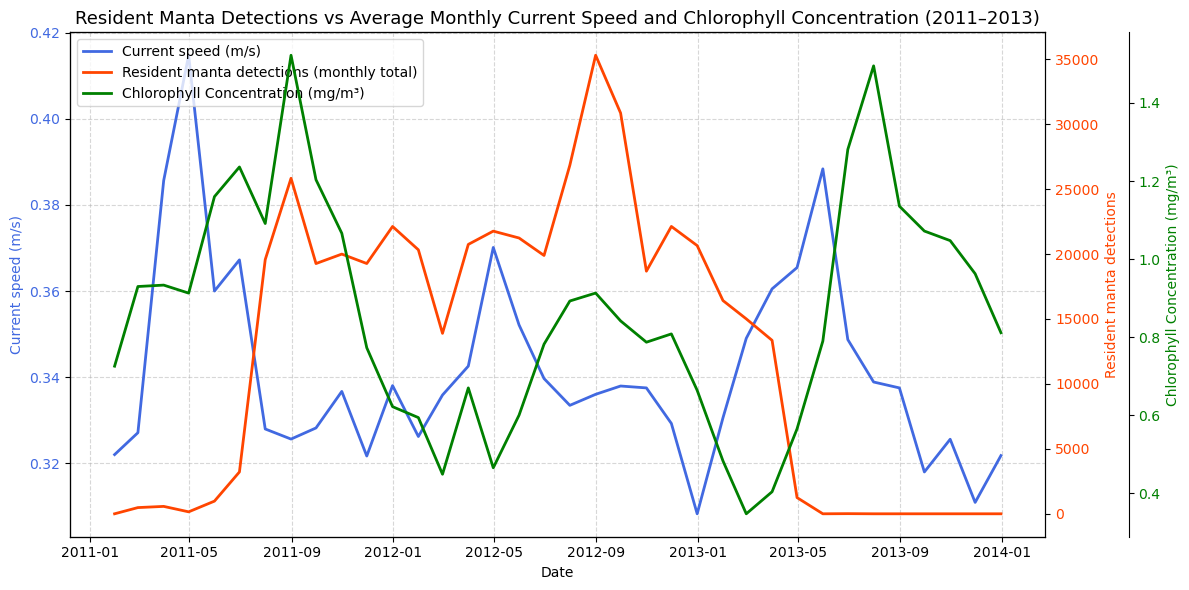

In [83]:
# --- Prepare figure ---
fig, ax1 = plt.subplots(figsize=(12,6))

# --- Left y-axis: current speed ---
ax1.plot(merged_monthly.index, merged_monthly['current_speed'], color='royalblue', lw=2, label='Current speed (m/s)')
ax1.set_ylabel('Current speed (m/s)', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Right y-axis: manta detections ---
ax2 = ax1.twinx()
ax2.plot(merged_monthly.index, merged_monthly['resident_detections'], color='orangered', lw=2, label='Resident manta detections (monthly total)')
ax2.set_ylabel('Resident manta detections', color='orangered')
ax2.tick_params(axis='y', labelcolor='orangered')

# --- Third y-axis: chlorophyll ---
ax3 = ax1.twinx()
# Move third axis a bit to the right
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(merged_monthly.index, merged_monthly['chlorophyll'], color='green', lw=2, label='Chlorophyll Concentration (mg/m³)')
ax3.set_ylabel('Chlorophyll Concentration (mg/m³)', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# --- X-axis ---
ax1.set_xlabel('Date')
ax1.set_title('Resident Manta Detections vs Average Monthly Current Speed and Chlorophyll Concentration (2011–2013)', fontsize=13)

# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper left')

plt.tight_layout()
plot_path = os.path.join(folders["plots"], "combined_res_manta_chl_cur_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

### Total Manta Detections vs eReefs Variables

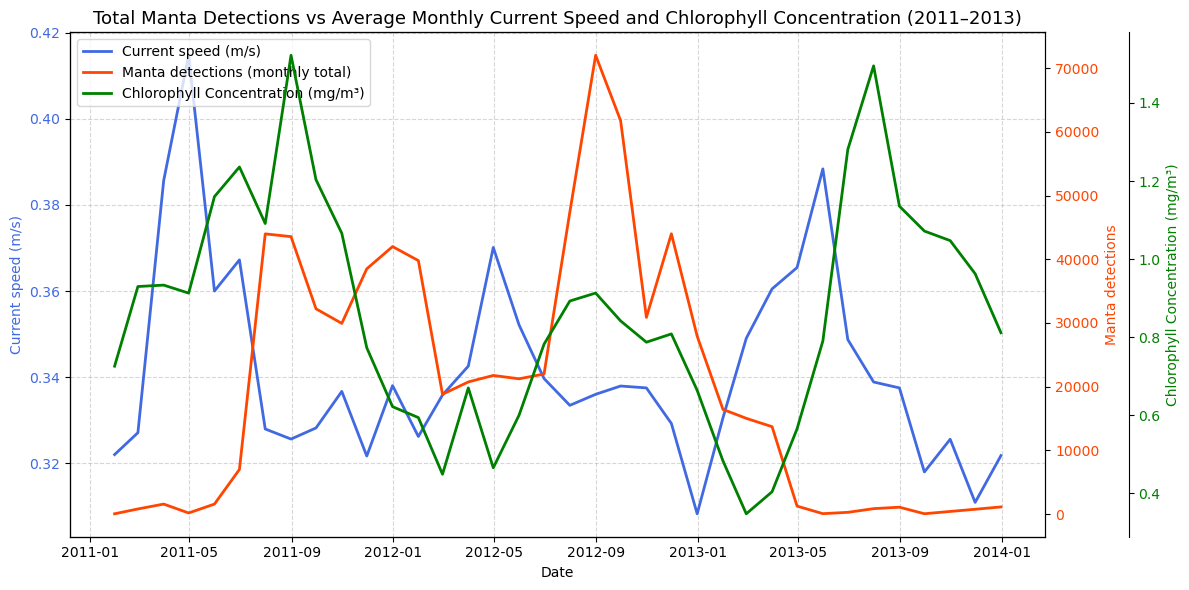

In [84]:
# --- Prepare figure ---
fig, ax1 = plt.subplots(figsize=(12,6))

# --- Left y-axis: current speed ---
ax1.plot(all_merged_monthly.index, all_merged_monthly['current_speed'], color='royalblue', lw=2, label='Current speed (m/s)')
ax1.set_ylabel('Current speed (m/s)', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Right y-axis: manta detections ---
ax2 = ax1.twinx()
ax2.plot(all_merged_monthly.index, all_merged_monthly['total_detections'], color='orangered', lw=2, label='Manta detections (monthly total)')
ax2.set_ylabel('Manta detections', color='orangered')
ax2.tick_params(axis='y', labelcolor='orangered')

# --- Third y-axis: chlorophyll ---
ax3 = ax1.twinx()
# Move third axis a bit to the right
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(all_merged_monthly.index, all_merged_monthly['chlorophyll'], color='green', lw=2, label='Chlorophyll Concentration (mg/m³)')
ax3.set_ylabel('Chlorophyll Concentration (mg/m³)', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# --- X-axis ---
ax1.set_xlabel('Date')
ax1.set_title('Total Manta Detections vs Average Monthly Current Speed and Chlorophyll Concentration (2011–2013)', fontsize=13)

# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper left')

plt.tight_layout()
plot_path = os.path.join(folders["plots"], "combined_all_manta_chl_cur_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

### Total and Resident Manta Detections vs eReefs Variables

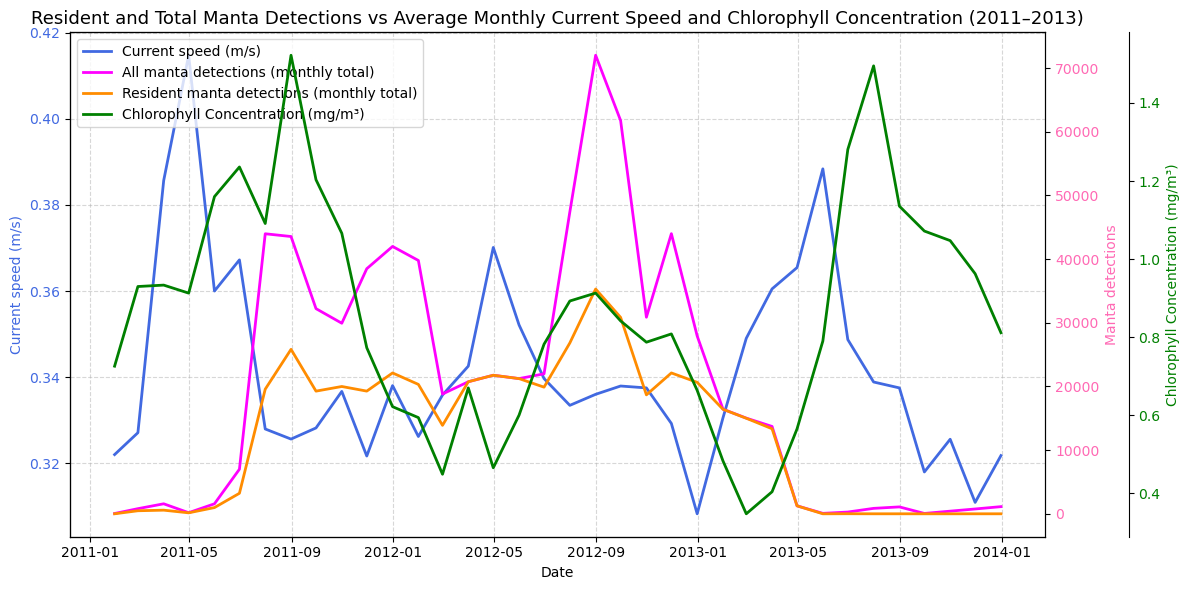

In [85]:
# --- Prepare figure ---
fig, ax1 = plt.subplots(figsize=(12,6))

# --- Left y-axis: current speed ---
ax1.plot(all_merged_monthly.index, all_merged_monthly['current_speed'], color='royalblue', lw=2, label='Current speed (m/s)')
ax1.set_ylabel('Current speed (m/s)', color='royalblue')
ax1.tick_params(axis='y', labelcolor='royalblue')
ax1.grid(True, linestyle='--', alpha=0.5)

# --- Right y-axis: total manta detections ---
ax2 = ax1.twinx()
ax2.plot(all_merged_monthly.index, all_merged_monthly['total_detections'], color='fuchsia', lw=2, label='All manta detections (monthly total)')
ax2.set_ylabel('Manta detections', color='hotpink')
ax2.tick_params(axis='y', labelcolor='hotpink')

# --- Right y-axis: resident manta detections ---
ax2.plot(all_merged_monthly.index, all_merged_monthly['resident_detections'], color='darkorange', lw=2, label='Resident manta detections (monthly total)')

# --- Third y-axis: chlorophyll ---
ax3 = ax1.twinx()
# Move third axis a bit to the right
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(all_merged_monthly.index, all_merged_monthly['chlorophyll'], color='green', lw=2, label='Chlorophyll Concentration (mg/m³)')
ax3.set_ylabel('Chlorophyll Concentration (mg/m³)', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# --- X-axis ---
ax1.set_xlabel('Date')
ax1.set_title('Resident and Total Manta Detections vs Average Monthly Current Speed and Chlorophyll Concentration (2011–2013)', fontsize=13)

# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines_3, labels_3 = ax3.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2 + lines_3, labels_1 + labels_2 + labels_3, loc='upper left')

plt.tight_layout()
plot_path = os.path.join(folders["plots"], "all_vs_resident_manta_timeseries.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

# Step 6 - Regression Analysis

## **Prepare and Inspect Data**

Load stats dependancies, check 

In [7]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the index is datetime
all_merged_df.index = pd.to_datetime(all_merged_df.index)

# Drop missing values
all_merged_df = all_merged_df.dropna(subset=["resident_detections", "total_detections", "current_speed", "chlorophyll"])

# Generate statistical summary of dataframe variables (mean, std, etc.) 
all_merged_df.describe()

,chlorophyll,current_speed,resident_detections,total_detections
count,979.000000,979.000000,979.000000,979.000000
mean,0.807695,0.337231,459.391216,729.801839
std,0.338175,0.063710,273.297151,274.156042
min,0.172649,0.170456,2.000000,2.000000
25%,0.565003,0.288936,154.500000,600.000000
50%,0.761599,0.333974,557.000000,714.000000
75%,0.998447,0.386032,691.000000,851.500000
max,2.113291,0.568106,842.000000,1433.000000


Define response and predictor variables

In [8]:
# Set independent (response) variable
y = all_merged_df["total_detections"]

# # Switch out for line above after running analysis to test correlation with resident mantas
# y = all_merged_df["resident_detections"]

# Set dependent (predictor) variables
X1 = all_merged_df[["current_speed"]]
X2 = all_merged_df[["chlorophyll"]]
X3 = all_merged_df[["current_speed", "chlorophyll"]]  # Mixed model

Add a constant term for the intercept (in order to run statsmodel)

In [9]:
X1 = sm.add_constant(X1)
X2 = sm.add_constant(X2)
X3 = sm.add_constant(X3)

## **Fit Regression Models**

In [10]:
model_1 = sm.OLS(y, X1).fit()
model_2 = sm.OLS(y, X2).fit()
model_3 = sm.OLS(y, X3).fit()

## **Compare Model Performance**

Check summary statistics for each model

In [11]:
print(model_1.summary())
print(model_2.summary())
print(model_3.summary())

                            OLS Regression Results                            
Dep. Variable:       total_detections   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     15.40
Date:                Tue, 21 Oct 2025   Prob (F-statistic):           9.33e-05
Time:                        11:17:40   Log-Likelihood:                -6876.8
No. Observations:                 979   AIC:                         1.376e+04
Df Residuals:                     977   BIC:                         1.377e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           910.5474     46.879     19.423

Create summary table to consolidate results

In [12]:
import pandas as pd

# Extract key statistics into a DataFrame
def model_summary_to_df(model, name):
    summary_df = pd.DataFrame({
        'Coefficient': model.params,
        'Std Err': model.bse,
        't': model.tvalues,
        'P>|t|': model.pvalues
    })
    summary_df['Model'] = name
    return summary_df

# Combine all model summaries
df_summary = pd.concat([
    model_summary_to_df(model_1, 'Model 1'),
    model_summary_to_df(model_2, 'Model 2'),
    model_summary_to_df(model_3, 'Model 3')
])

# Display neatly
df_summary = df_summary.reset_index().rename(columns={'index': 'Variable'})
df_summary

,Variable,Coefficient,Std Err,t,P>|t|,Model
0,const,910.547424,46.879170,19.423284,2.568568e-71,Model 1
1,current_speed,-535.970363,136.598333,-3.923696,9.330587e-05,Model 1
2,const,607.533139,22.309588,27.231930,5.917287e-122,Model 2
3,chlorophyll,151.379698,25.480159,5.941081,3.933983e-09,Model 2
4,const,809.664039,48.498298,16.694690,3.120016e-55,Model 3
5,current_speed,-630.085650,134.611618,-4.680767,3.261528e-06,Model 3
6,chlorophyll,164.197941,25.360089,6.474660,1.502987e-10,Model 3


Create summary table to easily compare models

In [13]:
comparison = pd.DataFrame({
    "Model": ["Current Speed", "Chlorophyll", "Current Speed + Chlorophyll"],
    "R²": [model_1.rsquared, model_2.rsquared, model_3.rsquared],
    "Adj. R²": [model_1.rsquared_adj, model_2.rsquared_adj, model_3.rsquared_adj],
    "AIC": [model_1.aic, model_2.aic, model_3.aic],
    "BIC": [model_1.bic, model_2.bic, model_3.bic]
})

comparison.sort_values("Adj. R²", ascending=False)

,Model,R²,Adj. R²,AIC,BIC
2,Current Speed + Chlorophyll,0.056058,0.054123,13718.422045,13733.081640
1,Chlorophyll,0.034868,0.033880,13738.155930,13747.928993
0,Current Speed,0.015513,0.014506,13757.594103,13767.367166


## **Visualize Model Fit**

### Plot simple regression models

*Current Speed vs Total Mantas*

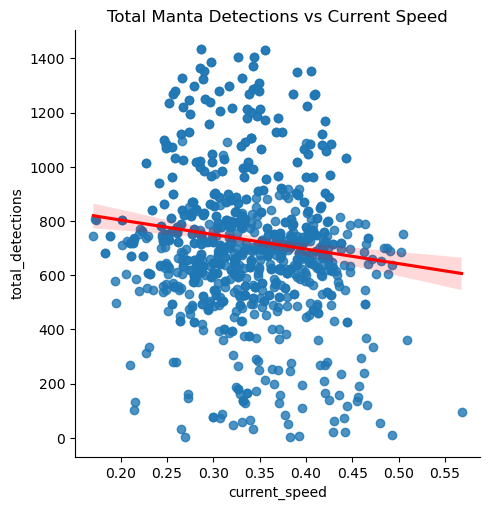

In [15]:
sns.lmplot(data=all_merged_df, x="current_speed", y="total_detections", line_kws={'color': 'red'})
plt.title("Total Manta Detections vs Current Speed")
plot_path = os.path.join(folders["regression"], "total_manta_current.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

*Chlorophyll vs Total Mantas*

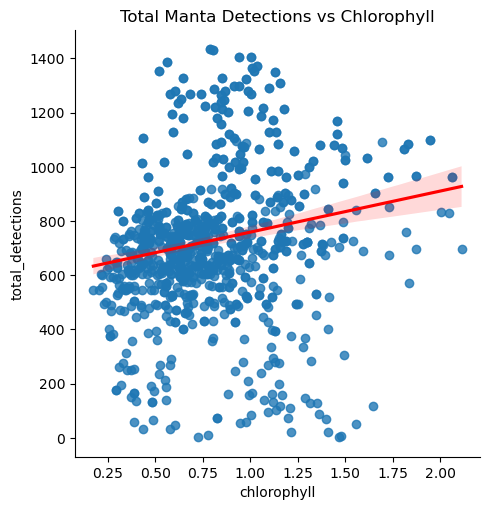

In [16]:
sns.lmplot(data=all_merged_df, x="chlorophyll", y="total_detections", line_kws={'color': 'red'})
plt.title("Total Manta Detections vs Chlorophyll")
plot_path = os.path.join(folders["regression"], "total_manta_chlorophyll.png")
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()

## **Check Assumptions**

Create a quantile-quantile plot of mixed model residuals to see how close our data is to being normally distributed (how reliable our coefficients and significance tests are)

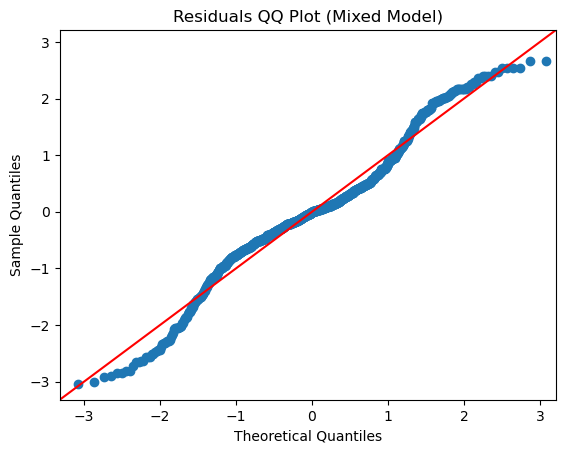

In [17]:
sm.qqplot(model_3.resid, line='45', fit=True)
plt.title("Residuals QQ Plot (Mixed Model)")
plt.show()